In [1]:
## Importing relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import datetime as dt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import sagemaker
import boto3
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role
# !pip install -U sagemaker


In [1]:
bucket = 'mf-ml-ds'

prefix = 'propensity_to_fund/source'

s3_surce_path = 's3://{}/propensity_to_fund/source'.format(bucket)
df = pd.read_csv('{}/ppf_dev3.csv'.format(s3_surce_path))


NameError: name 'pd' is not defined

# Feature Engineering

In [3]:
#apply the p1 p99 first then do the missing impute with max (p99) value or min value (p1), all data is capped at p99
ptable = pd.DataFrame()

for col in df.columns:
    percentiles = df[col].quantile([0.01,0.99]).values
    ptable[col]=percentiles
    
    

In [4]:
ptable.to_csv('../propensity_to_fund/model_monitor/capfloor.csv', index=False)

In [5]:
def setMax(df, pdf, var):

      df[var].fillna(pdf.max()[var], inplace=True)

In [6]:
def impute_ppf(df, ptable):
    for col in df.columns:
        p1 = ptable[col].min()
        p99= ptable[col].max()
        
    
        df.loc[df[col] <= p1, col] = p1
        df.loc[df[col] >= p99, col] = p99    

    items=['req_loan_amt','sixty_plus_dlq_all_la4', 'tot_open_to_buy_bankcard_ope','tot_open_to_buy_bankcard_ope','coll_gt_300_non_medical_2', 
       'credit_inq_retail_lst_6_m','mth_since_most_rec_non_finan',  'mth_since_most_rec_credit_ca',
       'tot_credit_limit_revolving_o','current_bal_revolving_closed','mth_since_most_rec_acct_o0',
       'pmt_non_mortgage_closed','ficoscore','tot_joint_mortgage_pmt']
    for item in items:
        setMax(df, ptable, item)  

In [7]:
df=df.fillna(0)

In [8]:
#check the mean of each variable by the group by bad performance variable
df.groupby('fund_flag').mean()

,age,req_loan_amt,self_rpt_mortgage_or_rental,self_rpt_years_at_current_a,distancetobranch,No_of_open_home_equity_accou,mortgage_accts_opened_within,tot_joint_mortgage_pmt,mth_since_most_rec_acct_o0,mth_since_most_rec_acct_18,...,SR_empstatus_Hourly,SR_Hownership_Home,SR_OthResi,source_CK_API,contact_state_priority,ref_code_priority,utm_medium_priority,FPD_flag,ever60by4_flag,distancetobranch_Z
fund_flag,,,,,,,,,,,,,,,,,,,,,
0,41.248756,5794.558651,605.272118,0.307820,4.142629,0.012292,0.046741,114.385676,7.77226,23.73153,...,0.056543,0.26187,0.506122,0.361392,1.646624,1.436103,0.897638,2.000000,2.000000,0.779480
1,44.583554,5405.836452,1498.300310,0.510131,2.203979,0.015013,0.074519,108.161449,6.93689,26.02017,...,0.053892,0.33636,0.286575,0.402711,1.998814,1.868623,1.271425,0.012458,0.081044,0.869307


# ML preparation

In [9]:
#split the model development sample into train and test sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(df.drop(['fund_flag','FPD_flag','ever60by4_flag','SR_OthResi'], axis='columns'), df.fund_flag, test_size=0.3)

In [10]:
feature_names = X_train.loc[1:1,]

In [11]:
feature_names

,age,req_loan_amt,self_rpt_mortgage_or_rental,self_rpt_years_at_current_a,distancetobranch,No_of_open_home_equity_accou,mortgage_accts_opened_within,tot_joint_mortgage_pmt,mth_since_most_rec_acct_o0,mth_since_most_rec_acct_18,...,maxmonthly_pmt,self_rpt_hhld_annual_i,borrower_type_FB,SR_empstatus_Hourly,SR_Hownership_Home,source_CK_API,contact_state_priority,ref_code_priority,utm_medium_priority,distancetobranch_Z
1,31,2000,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,60000,0,1,0,1,4,2,1,1


# XGBoost container expects CSV data format on S3

In [12]:
train_csv = 'train.csv'
validation_csv = 'validation.csv'
feature_csv='feature.csv'

In [13]:
pd.concat([y_train.to_frame(), X_train], axis=1).to_csv(train_csv, index=False, header=False)
pd.concat([y_test.to_frame(), X_test], axis=1).to_csv(validation_csv, index=False, header=False)
feature_names.to_csv(feature_csv,index=False)

In [14]:
role = get_execution_role()            ## Run this before the training job to get your IAM role
region = boto3.Session().region_name   ## Run this here, you will need it during training


boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/'+ train_csv )).upload_file(train_csv)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/' + validation_csv)).upload_file(validation_csv)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'feature/' + feature_csv)).upload_file(feature_csv)

In [16]:
!rm {train_csv} {validation_csv} {feature_csv}


rm: cannot remove ‘train.csv’: No such file or directory


# Model training

In [17]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput


In [18]:
role = get_execution_role()


In [19]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1" )

In [20]:
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1'

In [21]:

# container = get_image_uri(region, 'xgboost', "1.2-1")
sms = sagemaker.Session()


In [43]:
train_data_path      = 's3://{}/{}/{}'.format(bucket, prefix, 'train')
validation_data_path = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')
s3_output_location   = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
feature_location = 's3://{}/{}/{}'.format(bucket, prefix, 'feature')

In [44]:
df_feature = pd.read_csv(feature_location+'/feature.csv')

In [45]:
feature_names = df_feature.columns


In [46]:
nfeatures = str(len(feature_names))

In [47]:
s3_input_train = TrainingInput(s3_data=train_data_path, content_type='csv')
s3_input_validation = TrainingInput(s3_data=validation_data_path, content_type='csv')

In [88]:
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs,CollectionConfig

In [89]:
save_interval = 5
profiler_config=ProfilerConfig()
debugger_hook_config=DebuggerHookConfig(
    s3_output_path = s3_output_location,
    collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
#             CollectionConfig(
#                 name="feature_importance",
#                 parameters={
#                     "save_interval": str(save_interval)
#                 }
#             ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ]
)

In [90]:
rules=[
        #Rule.sagemaker(rule_configs.create_xgboost_report()),
       ProfilerRule.sagemaker(rule_configs.ProfilerReport())
       , Rule.sagemaker(
        base_config=rule_configs.feature_importance_overweight(),
        rule_parameters={
                "threshold": "0.0",
                "nfeatures": nfeatures
                ,"tensor_regex": ".*feature_importance/weight"
                    },
         collections_to_save=[
            CollectionConfig(
                name="feature_importance"
               ,parameters={
                    "save_interval": "5"
                } 
            )
         ]
    )
]

In [91]:
rules

[ProfilerRule(name='ProfilerReport', image_uri='DEFAULT_RULE_EVALUATOR_IMAGE', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'rule_to_invoke': 'ProfilerReport'}),
 Rule(name='FeatureImportanceOverweight', image_uri='DEFAULT_RULE_EVALUATOR_IMAGE', instance_type=None, container_local_output_path=None, s3_output_path=None, volume_size_in_gb=None, rule_parameters={'rule_to_invoke': 'FeatureImportanceOverweight', 'threshold': '0.0', 'nfeatures': '50', 'tensor_regex': '.*feature_importance/weight'})]

In [92]:

xgb = sagemaker.estimator.Estimator(
                                    container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m5.xlarge',
                                    output_path=s3_output_location,
                                    sagemaker_session = sms,
                                    base_job_name = 'mf-ml-ppf-sm-xgb-jn',
    
                                    # Debugger-specific parameters
                                    profiler_config=profiler_config,
                                    debugger_hook_config=debugger_hook_config,
                                    rules=rules
                            )


In [93]:
xgb.set_hyperparameters(num_round=101,
                        max_depth=5,
                        eta=0.2,
                        objective='binary:logistic',
                        
                        base_score=0.5,
                        booster='gbtree',
                        gamma=4,
                        sample_type= 'weighted',
                        min_child_weight=5,
                     
                        seed=42,
                        subsample=0.7,
                        verbosity=1,
                        eval_metric='auc'
                       )


In [94]:
data_channels = {'train': s3_input_train, 'validation': s3_input_validation}

In [95]:
xgb.fit(data_channels,logs='All')


2021-03-29 17:27:42 Starting - Starting the training job...
2021-03-29 17:27:44 Starting - Launching requested ML instancesFeatureImportanceOverweight: InProgress
ProfilerReport: InProgress
......
2021-03-29 17:28:59 Starting - Preparing the instances for training......
2021-03-29 17:30:00 Downloading - Downloading input data
2021-03-29 17:30:00 Training - Downloading the training image...
2021-03-29 17:30:40 Training - Training image download completed. Training in progress..[2021-03-29 17:30:42.140 ip-10-0-96-244.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter sample_type value weighted to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter booster value gbtree to Json.
Return

In [67]:
# from sagemaker.transformer import transformer
from sagemaker.predictor import Predictor

In [98]:
xgb.model_data

's3://mf-ml-ds/propensity_to_fund/source/xgboost_model_sdk/mf-ml-ppf-sm-xgb-jn-2021-03-29-17-27-42-188/output/model.tar.gz'

In [99]:
xgb.latest_job_debugger_artifacts_path()

's3://mf-ml-ds/propensity_to_fund/source/xgboost_model_sdk/mf-ml-ppf-sm-xgb-jn-2021-03-29-17-27-42-188/debug-output'

In [100]:
from smdebug.trials import create_trial
s3_output_path = xgb.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2021-03-29 17:48:53.120 ip-172-16-50-54:1936 INFO s3_trial.py:42] Loading trial debug-output at path s3://mf-ml-ds/propensity_to_fund/source/xgboost_model_sdk/mf-ml-ppf-sm-xgb-jn-2021-03-29-17-27-42-188/debug-output


In [101]:
from itertools import islice
import matplotlib.pyplot as plt
import re
import seaborn as sns

MAX_PLOTS = int(nfeatures)

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1]=="f{}".format(str(ifeat)): return feature_name
    return tensor_name

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names
    
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    
    print (matched_tensors)
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial,"feature_importance",regex=f"feature_importance/{importance_type}/.*")

In [102]:
def get_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    return get_collection(trial,"feature_importance",regex=f"feature_importance/{importance_type}/.*")

In [103]:
def get_data_last_step(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    vals = trial.tensor(tname).value(trial.last_complete_step)
    #print (type(vals))
    return float(vals[0])

In [104]:
def get_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    #fig, ax = plt.subplots(figsize=figsize)
    #sns.despine()
    df = pd.DataFrame(columns = ['tensore_name','feature_name','feature_importance'])
    #df = pd.DataFrame(columns = ['Name', 'Articles', 'Improved'])
    tensors = trial.collection(collection_name).tensor_names

    matched_tensors = [t for t in tensors if re.match(regex, t)]
    
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        if re.match(regex, tensor_name):
            #print(type(match_tensor_name_with_feature_name(tensor_name)))
            #print(tensor_name, get_data_last_step(trial, tensor_name), match_tensor_name_with_feature_name(tensor_name))
            #tn, td , tl = tensor_name, get_data_last_step(trial, tensor_name), match_tensor_name_with_feature_name(tensor_name)
            #df["Name"] = tensor_name
            df = df.append({
                            'tensore_name' : tensor_name,
                            'feature_name' : match_tensor_name_with_feature_name(tensor_name),
                            'feature_importance' : get_data_last_step(trial, tensor_name)
                           },
                           ignore_index=True
                          )
            #steps, data = get_data(trial, tensor_name)
            #ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))
    return df

In [105]:
df_fi = get_feature_importance(trial, "weight")

In [106]:
df_fi.sort_values("feature_importance",ascending=False)


,tensore_name,feature_name,feature_importance
2,feature_importance/weight/f41,self_rpt_hhld_annual_i,0.072014
12,feature_importance/weight/f36,ficoscore,0.070289
10,feature_importance/weight/f11,maxhigh_credit_installment_,0.063821
8,feature_importance/weight/f0,age,0.060802
5,feature_importance/weight/f1,req_loan_amt,0.034498
1,feature_importance/weight/f2,self_rpt_mortgage_or_rental,0.032773
6,feature_importance/weight/f47,ref_code_priority,0.029754
11,feature_importance/weight/f17,current_bal_personal_loan_in,0.028461
13,feature_importance/weight/f25,No_of_opened_accts_person,0.027167
4,feature_importance/weight/f38,No_of_accts_sec_closed,0.024580


['validation-auc', 'train-auc']
[2021-03-29 17:54:50.615 ip-172-16-50-54:1936 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-03-29 17:54:51.690 ip-172-16-50-54:1936 INFO trial.py:210] Loaded all steps


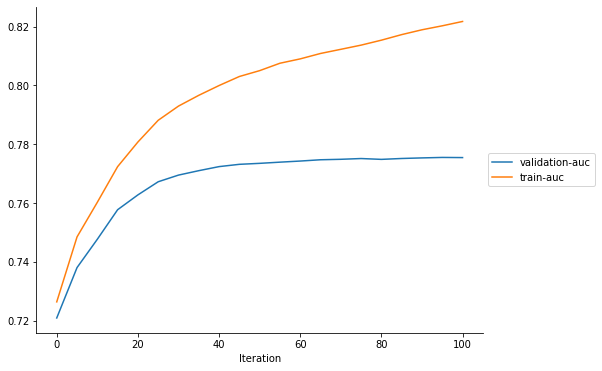

In [107]:
plot_collection(trial, "metrics")

['feature_importance/weight/f42', 'feature_importance/weight/f2', 'feature_importance/weight/f41', 'feature_importance/weight/f37', 'feature_importance/weight/f38', 'feature_importance/weight/f1', 'feature_importance/weight/f47', 'feature_importance/weight/f48', 'feature_importance/weight/f0', 'feature_importance/weight/f40', 'feature_importance/weight/f11', 'feature_importance/weight/f17', 'feature_importance/weight/f36', 'feature_importance/weight/f25', 'feature_importance/weight/f45']


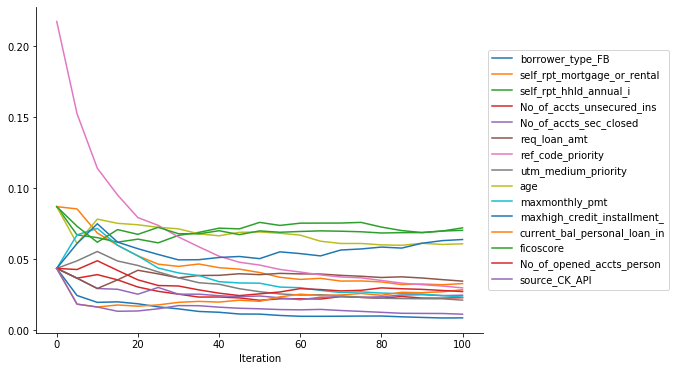

In [108]:
plot_feature_importance(trial)

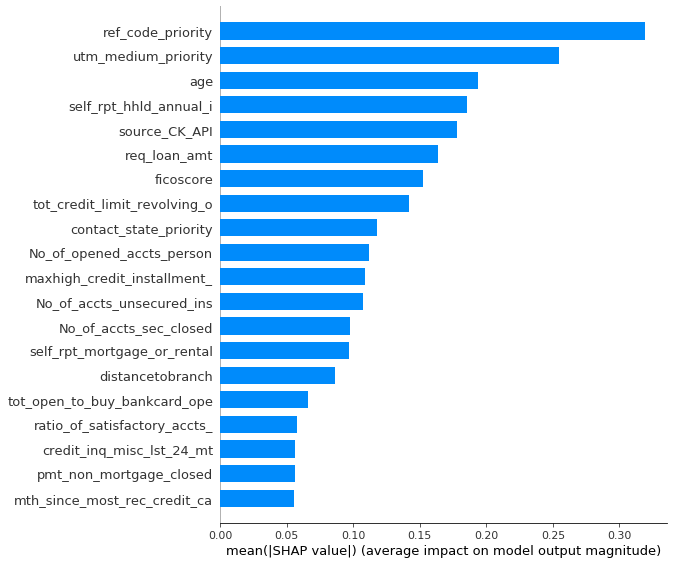

In [109]:
import shap
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

In [1]:
import sagemaker
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

NameError: name 'xgb' is not defined

In [111]:
import numpy as np
def predict(data, model, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

## Generate predictions on the test set for the difference models





In [112]:
X_test.head()

,age,req_loan_amt,self_rpt_mortgage_or_rental,self_rpt_years_at_current_a,distancetobranch,No_of_open_home_equity_accou,mortgage_accts_opened_within,tot_joint_mortgage_pmt,mth_since_most_rec_acct_o0,mth_since_most_rec_acct_18,...,maxmonthly_pmt,self_rpt_hhld_annual_i,borrower_type_FB,SR_empstatus_Hourly,SR_Hownership_Home,source_CK_API,contact_state_priority,ref_code_priority,utm_medium_priority,distancetobranch_Z
219796,30,6500,0.0,0.0,0.0,0.0,0.0,0.0,6.0,14.0,...,106.07,50000,0,1,0,1,1,0,1,1
248455,35,2500,0.0,0.0,0.0,0.0,1.0,948.0,9.0,9.0,...,0.00,48000,0,0,1,0,1,0,0,1
9670,56,1500,1950.0,0.0,9.0,0.0,0.0,0.0,8.0,8.0,...,0.00,117000,0,0,1,0,2,1,2,0
119497,65,1500,0.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,...,0.00,39000,0,0,1,0,0,0,0,1
119424,36,1500,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,...,0.00,50000,0,1,0,1,1,2,1,1


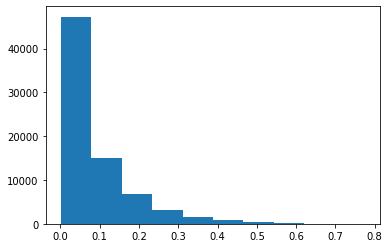

In [113]:
import matplotlib.pyplot as plt


predictions = predict(X_test.to_numpy(), xgb_predictor)
plt.hist(predictions)
plt.show()


AUC is 0.7754


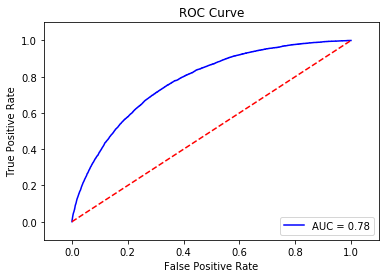

In [114]:
y_pred=predictions

from sklearn import metrics

auc = round(roc_auc_score(y_test, y_pred), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()





In [115]:
import sys
sys.path.insert(0, '/home/ec2-user/SageMaker/mymodule/')

from common_functions import psi
from common_functions import ks

In [116]:
import pandas as pd

#merge only the test dataset
y_test_hat=predictions

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_test.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='fund_flag', prob='Y_hats')

      min_score  max_score  events  nonevents  total event_rate nonevent_rate  \
0      0.211699   0.775667    2194       5332   7526     29.15%        70.85%   
1      0.139807   0.211697    1319       6206   7525     17.53%        82.47%   
2     0.0986427   0.139794     937       6588   7525     12.45%        87.55%   
3     0.0718881  0.0986425     680       6845   7525      9.04%        90.96%   
4      0.053397  0.0718879     497       7028   7525      6.60%        93.40%   
5     0.0392848  0.0533921     399       7126   7525      5.30%        94.70%   
6     0.0285423  0.0392847     254       7271   7525      3.38%        96.62%   
7     0.0195565  0.0285422     183       7342   7525      2.43%        97.57%   
8     0.0117055  0.0195564     107       7417   7524      1.42%        98.58%   
9   0.000899134  0.0117051      61       7466   7527      0.81%        99.19%   
10                            6631      68621  75252      8.81%        91.19%   

   % events % nonevents % c

In [117]:
df_val = pd.read_csv('{}/ppf_val3.csv'.format(s3_surce_path))

In [118]:
impute_ppf(df_val, ptable)
df_val=df_val.fillna(0)


In [119]:
droplist = ['fund_flag','FPD_flag','ever60by4_flag','SR_OthResi']

In [120]:
X_val = df_val.loc[: , ~df_val.columns.isin(droplist)]
y_val = df_val.loc[: ,'fund_flag']
y_val_FPD=df_val.loc[:,'FPD_flag']
y_val_ever60by4=df_val.loc[:,'ever60by4_flag']


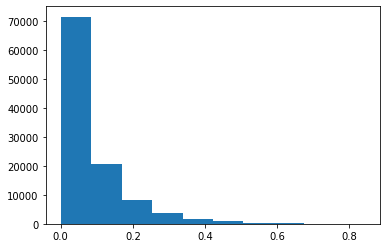

In [121]:
predictions = predict(X_val.to_numpy(), xgb_predictor)
plt.hist(predictions)
plt.show()

In [122]:
y_val_hat=predictions

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_val_hat_df=pd.DataFrame(data=y_val_hat, columns=['Y_hats'], index=X_val.index.copy())

df_out=pd.merge(y_val, y_val_hat_df, how='left', left_index=True, right_index=True)
ks_val=ks(data=df_out, target='fund_flag', prob='Y_hats')

      min_score  max_score  events  nonevents     total event_rate  \
0      0.208719   0.843422  3143.0     7623.0   10766.0     29.19%   
1      0.134343   0.208707  1862.0     8903.0   10765.0     17.30%   
2     0.0945728   0.134342  1295.0     9470.0   10765.0     12.03%   
3     0.0693558  0.0945714   999.0     9766.0   10765.0      9.28%   
4     0.0514383  0.0693547   716.0    10049.0   10765.0      6.65%   
5     0.0379056  0.0514383   491.0    10275.0   10766.0      4.56%   
6     0.0274226  0.0379042   346.0    10419.0   10765.0      3.21%   
7     0.0188511  0.0274217   273.0    10492.0   10765.0      2.54%   
8     0.0112802  0.0188502   160.0    10605.0   10765.0      1.49%   
9   0.000238926  0.0112797   104.0    10662.0   10766.0      0.97%   
10                          9389.0    98264.0  107653.0      8.72%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         70.81%   33.48%       7.76%       33.48%           7.76%  25.7  
1        

In [123]:
df_out_FPD=pd.merge(y_val_FPD, df_out, how='left', left_index=True, right_index=True)
df_out_FPD=df_out_FPD[df_out_FPD['FPD_flag'] !=2]
ks_val_FPD=ks(data=df_out_FPD, target='FPD_flag', prob='Y_hats')

     min_score  max_score  events  nonevents   total event_rate nonevent_rate  \
0     0.371472   0.843422     4.0      935.0   939.0      0.43%        99.57%   
1     0.283008   0.371411     4.0      935.0   939.0      0.43%        99.57%   
2     0.224408   0.282977     5.0      934.0   939.0      0.53%        99.47%   
3     0.182707   0.224397     8.0      931.0   939.0      0.85%        99.15%   
4     0.145393    0.18266     9.0      929.0   938.0      0.96%        99.04%   
5     0.113894   0.145377    15.0      924.0   939.0      1.60%        98.40%   
6    0.0873947   0.113855    13.0      926.0   939.0      1.38%        98.62%   
7    0.0639974  0.0873914    16.0      923.0   939.0      1.70%        98.30%   
8    0.0391574  0.0639396    19.0      920.0   939.0      2.02%        97.98%   
9   0.00054979  0.0390963    18.0      921.0   939.0      1.92%        98.08%   
10                          111.0     9278.0  9389.0      1.18%        98.82%   

   % events % nonevents % c

In [124]:
df_out_ever60by4=pd.merge(y_val_ever60by4, df_out, how='left', left_index=True, right_index=True)
df_out_ever60by4=df_out_ever60by4[df_out_ever60by4['ever60by4_flag'] !=2]
ks_val_ever60by4=ks(data=df_out_ever60by4, target='ever60by4_flag', prob='Y_hats')

     min_score  max_score  events  nonevents   total event_rate nonevent_rate  \
0     0.371691   0.843422    10.0      905.0   915.0      1.09%        98.91%   
1     0.283709   0.371683    12.0      903.0   915.0      1.31%        98.69%   
2     0.225262   0.283676    15.0      899.0   914.0      1.64%        98.36%   
3     0.183424   0.225146    16.0      899.0   915.0      1.75%        98.25%   
4     0.146064   0.183298    25.0      889.0   914.0      2.74%        97.26%   
5     0.114397   0.146024    30.0      885.0   915.0      3.28%        96.72%   
6    0.0878669   0.114338    33.0      882.0   915.0      3.61%        96.39%   
7       0.0641   0.087849    30.0      884.0   914.0      3.28%        96.72%   
8    0.0392317   0.064057    36.0      879.0   915.0      3.93%        96.07%   
9   0.00054979  0.0391574    44.0      871.0   915.0      4.81%        95.19%   
10                          251.0     8896.0  9147.0      2.74%        97.26%   

   % events % nonevents % c

In [125]:
df_oot = pd.read_csv('{}/ppf_oot3.csv'.format(s3_surce_path))

In [126]:
impute_ppf(df_oot, ptable)
df_oot=df_oot.fillna(0)

In [127]:
X_oot = df_oot.loc[: , ~df_val.columns.isin(droplist)]
y_oot = df_oot.loc[: ,'fund_flag']
y_oot_FPD=df_oot.loc[:,'FPD_flag']
y_oot_ever60by4=df_oot.loc[:,'ever60by4_flag']


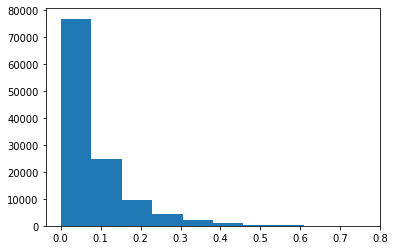

In [128]:
predictions = predict(X_oot.to_numpy(), xgb_predictor)
plt.hist(predictions)
plt.show()


In [129]:
y_oot_hat=predictions

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_oot_hat_df=pd.DataFrame(data=y_oot_hat, columns=['Y_hats'], index=X_oot.index.copy())

df_out=pd.merge(y_oot, y_oot_hat_df, how='left', left_index=True, right_index=True)
ks_oot=ks(data=df_out, target='fund_flag', prob='Y_hats')


      min_score  max_score  events  nonevents     total event_rate  \
0       0.18847   0.762183  3151.0     8767.0   11918.0     26.44%   
1      0.124364   0.188468  1857.0    10060.0   11917.0     15.58%   
2     0.0899274   0.124363  1340.0    10577.0   11917.0     11.24%   
3     0.0672882  0.0899242  1019.0    10898.0   11917.0      8.55%   
4     0.0510562  0.0672882   791.0    11126.0   11917.0      6.64%   
5     0.0389328  0.0510558   575.0    11342.0   11917.0      4.83%   
6     0.0291503  0.0389321   453.0    11464.0   11917.0      3.80%   
7     0.0208143  0.0291484   300.0    11617.0   11917.0      2.52%   
8     0.0131221  0.0208141   222.0    11695.0   11917.0      1.86%   
9   0.000190172  0.0131219   137.0    11781.0   11918.0      1.15%   
10                          9845.0   109327.0  119172.0      8.26%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         73.56%   32.01%       8.02%       32.01%           8.02%  24.0  
1        

In [130]:
df_out_FPD=pd.merge(y_oot_FPD, df_out, how='left', left_index=True, right_index=True)
df_out_FPD=df_out_FPD[df_out_FPD['FPD_flag'] !=2]
ks_oot_FPD=ks(data=df_out_FPD, target='FPD_flag', prob='Y_hats')

      min_score  max_score  events  nonevents   total event_rate  \
0      0.337076   0.762183     3.0      980.0   983.0      0.31%   
1      0.249249   0.336953     9.0      973.0   982.0      0.92%   
2      0.196322   0.249198     2.0      981.0   983.0      0.20%   
3      0.159247   0.196322     1.0      981.0   982.0      0.10%   
4       0.12714   0.159219    11.0      972.0   983.0      1.12%   
5      0.101193      0.127     8.0      974.0   982.0      0.81%   
6     0.0776873   0.101181     8.0      975.0   983.0      0.81%   
7      0.057229  0.0776798    16.0      966.0   982.0      1.63%   
8     0.0363117  0.0572042    19.0      964.0   983.0      1.93%   
9   0.000505634  0.0362699    14.0      969.0   983.0      1.42%   
10                            91.0     9735.0  9826.0      0.93%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         99.69%    3.30%      10.07%        3.30%          10.07%   6.8  
1         99.08%    9.89%       9

In [131]:
df_out_ever60by4=pd.merge(y_oot_ever60by4, df_out, how='left', left_index=True, right_index=True)
df_out_ever60by4=df_out_ever60by4[df_out_ever60by4['ever60by4_flag'] !=2]
ks_oot_ever60by4=ks(data=df_out_ever60by4, target='ever60by4_flag', prob='Y_hats')

      min_score  max_score  events  nonevents   total event_rate  \
0      0.341481   0.762183     6.0      889.0   895.0      0.67%   
1      0.251577    0.34132    11.0      883.0   894.0      1.23%   
2      0.197951    0.25138     6.0      889.0   895.0      0.67%   
3      0.160449   0.197925     7.0      887.0   894.0      0.78%   
4      0.128473   0.160449     5.0      890.0   895.0      0.56%   
5      0.102003   0.128451     9.0      885.0   894.0      1.01%   
6     0.0782552    0.10196     8.0      887.0   895.0      0.89%   
7      0.057678    0.07823    14.0      880.0   894.0      1.57%   
8     0.0368133   0.057675    15.0      880.0   895.0      1.68%   
9   0.000505634  0.0368098    18.0      877.0   895.0      2.01%   
10                            99.0     8847.0  8946.0      1.11%   

   nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
0         99.33%    6.06%      10.05%        6.06%          10.05%   4.0  
1         98.77%   11.11%       9

In [132]:
xgb_predictor.delete_endpoint()